# MASTER - Notebook 2
### Matteo Grazioso 884055

In [81]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

import myfunctions as mf # Custom functions

In [82]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [83]:
# The file contains the data of the validation of tickets in the city of public transport of Venice.
# The file has been created by the Notebook 1.ipynb

# Import the data into a dataframe of a txt file
# path = 'data/processed/dataset_cleaned_validazioni.txt'
path = 'data/processed/dataset_cleaned_esportazioneCompleta.txt'

df = pd.read_csv(path, header=0, sep='\t')

# Save the name of the file in a variable for future use extracting the name of the file from the path
file_name = path.split('_')[-1].split('.')[0]

# Display the first 5 rows of the dataframe
df.head()

# Convert the column 'DATA' to datetime format
df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')

In [84]:
# First 10% of the dataframe
# df = df.iloc[:int(len(df)*0.1)]

In [85]:
df.head()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
0,2023-01-13,00:00:00,2023-01-13 00:00:00,40834866809772548,162,STAZIONE MES,12101,7,BIGL.AUT.75'MESTRE/LIDO-TSC
1,2023-01-13,00:00:00,2023-01-13 00:00:00,-3604990320,5049,ZATTERE,23301,5-STUD,MENS.STUDENTE RETE UNICA
2,2023-01-13,00:00:00,2023-01-13 00:00:00,-2824230951,5043,"S. TOMA' ""B""",23303,6-STUD,ABB STUD. RETEUNICA 12 MESI
3,2023-01-13,00:00:00,2023-01-13 00:00:00,40552750134805252,5013,S. MARCO-SAN,11101,7,"75'-TPL 8,64-COMVE0,86"
4,2023-01-13,00:01:00,2023-01-13 00:01:00,-3604964420,6084,VENEZIA,11209,7,BIGL RETE UNICA 75'


In [86]:
df.tail()

,DATA,ORA,DATA_VALIDAZIONE,SERIALE,FERMATA,DESCRIZIONE,TITOLO,TICKET_CODE,DESCRIZIONE_TITOLO
494741,2023-01-20,22:42:00,2023-01-20 22:42:00,-2818102479,5013,S. MARCO-SAN,20003,5,MENSILE ORDINARIO ISOLE
494742,2023-01-20,22:42:00,2023-01-20 22:42:00,-3604974851,5013,S. MARCO-SAN,23101,5,MENSILE ORDINARIO RETE UNICA
494743,2023-01-20,22:42:00,2023-01-20 22:42:00,-2824243187,5039,RIALTO,23101,5,MENSILE ORDINARIO RETE UNICA
494744,2023-01-20,22:42:00,2023-01-20 22:42:00,41960766709400836,5031,P.LE ROMA,11107,2,"48H-TPL 29,90-COMVE5,10"
494745,2023-01-20,22:42:00,2023-01-20 22:42:00,41960766709396996,5031,P.LE ROMA,11107,2,"48H-TPL 29,90-COMVE5,10"


---------


## Trajectories

We are interested in analyzing the trajectories of the users that use the public transport in the city of Venice.

Note that the stops are identified by the *DESCRIZIONE* column that contains the name of the stop, so each trajectory 
is composed by the name of the stops visited by the user, so a trajectory is composed by a sequence of strings.

In [87]:
def create_dictionary_with_trajectories(df: pd.DataFrame) -> dict[str, datetime]:
    """
        This function creates a dictionary with the trajectories of the users.
        :param df: the dataframe
        :return: the dictionary with the trajectories of the users with the key (serial, day). 
            Notice: if the serial is the same for all the days the key is (serial, None)
    """
    # Create a dictionary with the trajectories of the users
    dict_trajectories = {}
    # For each user
    for serial in df['SERIALE'].unique():
        # NOTICE: the serial of ticket code 5, 5-STUD, 5-RET, 5-WKRS and the same with 6, change every day,
        # so the user is not the same, but the user is the same for the same day
        
        # Select only the rows of the specified user
        df_sup = df[df['SERIALE'] == serial].sort_values(by=['DATA', 'ORA'])

        # Create a list with the trajectories of the user
        list_trajectories = []
        
        # If the ticket code is 5, 5-STUD, 5-RET, 5-WKRS or 6, 6-STUD, 6-RET, 6-WKRS create a list with the trajectories 
        # for each day and for each serial
        if df_sup['TICKET_CODE'].unique()[0] in ['5', '5-STUD', '5-RET', '5-WKRS', '6', '6-STUD', '6-RET', '6-WKRS']:
            # print('Ticket code: {}'.format(df_sup['TICKET_CODE'].unique()[0]))
            # For each day
            for day in df_sup['DATA']:
                # Select only the rows of the specified day
                df_sup_sup = df_sup[df_sup['DATA'] == day]
                # For each serial
                for serial in df_sup_sup['SERIALE'].unique():
                    # Reset list_trajectories
                    list_trajectories = []
                    # Select only the rows of the specified serial
                    df_sup_sup_sup = df_sup_sup[df_sup_sup['SERIALE'] == serial]
                    # Create a list with the trajectories of the user
                    list_stop = df_sup_sup_sup['DESCRIZIONE'].tolist()
                    # Append the list to the list of the trajectories
                    list_trajectories.append(list_stop)
                    # Insert the list of the trajectories in the dictionary with the key (serial, day)
                    dict_trajectories[serial, day] = list_trajectories
        else:
            # Create a list with the trajectories of the user
            list_stop = df_sup['DESCRIZIONE'].tolist()
            list_trajectories.append(list_stop)
            # If the serial is already in the dictionary print a warning
            if (serial, None) in dict_trajectories:
                print('Warning: the serial {} is already in the dictionary'.format(serial))
                # launch an exception
                raise Exception('The serial {} is already in the dictionary'.format(serial))
            # Insert the list of the trajectories in the dictionary with the key (serial, None)
            # None means that the serial is the same for all the days
            dict_trajectories[serial, None] = list_trajectories

    return dict_trajectories

In [88]:
def number_of_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '', summary: bool = False) -> int:
    """
        This function computes the number of trajectories.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, focus on the ticket code
        :param ticket_code: the ticket code
        :return: the number of trajectories
    """
    # Create a dictionary with the number of trajectories
    dict_number_of_trajectories = {}
    # For each trajectory
    for trajectory in dict_trajectories.values():
        # If the trajectory is not in the dictionary, add it
        if str(trajectory) not in dict_number_of_trajectories.keys():
            dict_number_of_trajectories[str(trajectory)] = 1
        # If the trajectory is in the dictionary, increment the counter
        else:
            dict_number_of_trajectories[str(trajectory)] += 1

    if summary:
        # Print the number of trajectories
        if is_focus_on_ticket_code:
            print('The number of trajectories with ticket code {} - "{}" is: {}'.format(ticket_code, mf.get_ticket_code_description(ticket_code), len(dict_number_of_trajectories.keys())))
        else:
            print('The number of trajectories is: {}'.format(len(dict_number_of_trajectories.keys())))
    
    # Return the number of trajectories
    return len(dict_number_of_trajectories.keys())

In [89]:
def average_length_of_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '', summary: bool = False) -> float:
    """
        This function computes the average length of the trajectories.
        This function can receive a dictionary with the trajectories related to a specific ticket code: in this case the function prints this information.
        :param dict_trajectories: the dictionary with the trajectories of the users with the key (serial, day) or (serial, None)
        :param is_focus_on_ticket_code: if True, focus on the ticket code
        :param ticket_code: the ticket code
        :param summary: if True, print the summary
        :return: the average length of the trajectories 
    """
    # Notice that the key of the dictionary is a tuple (serial, day)
    # Compute the average length of the trajectories
    average_length = 0
    for chiave in dict_trajectories.keys():
        if chiave[1] is not None:
            average_length += len(dict_trajectories[chiave][0])
        else:
            average_length += len(dict_trajectories[chiave][0])
    if len(dict_trajectories.keys()) != 0:
        average_length /= len(dict_trajectories.keys())
        # Round the average length to 4 decimal places
        average_length = round(average_length, 4)
    else:
        average_length = -1
    
    if summary:
        if len (dict_trajectories.keys()) != 0:
            # Print the average length of the trajectories
            if is_focus_on_ticket_code:
                print('The average length of the trajectories with ticket code {} - "{}" is: {}'.format(ticket_code, mf.get_ticket_code_description(ticket_code), average_length))
            else:
                print('The average length of the trajectories is: {}'.format(average_length))
        else:
            print('WARNING: There are no trajectories to analyze')

    return average_length

In [90]:
def average_lenght_of_trajectories_per_ticket_code_stmp(df: pd.DataFrame):
    """
        This function computes the average length of the trajectories for each ticket code in the dataset.
        The order of the ticket codes is mantained because the ticket codes are stored in the dictionary "dict_ticket_codes.json".
        :param df: the dataframe
        :return: None
    """
    dict_trajectories = {}
    dict_ticket_codes = mf.open_dict_ticket_codes()

    # For each ticket code in the dictionary
    for ticket_code in dict_ticket_codes.keys():
        # Select only the rows of the specified ticket code
        df_sup = mf.focus_on_ticket_code(df, ticket_code)
        
        # If the dataframe is not empty, focus on the ticket code
        if df_sup.shape[0] != 0:
            # Create a dictionary with the trajectories of the users
            dict_trajectories[ticket_code] = create_dictionary_with_trajectories(df_sup)
            average_length_of_trajectories(dict_trajectories[ticket_code], is_focus_on_ticket_code=True, ticket_code=ticket_code)
        else:
            # If the dataframe is empty, skip the ticket code but launch a warning
            print('WARNING: There are no validations of the ticket code "{}"'.format(ticket_code))

In [91]:
def average_length_of_trajectories_by_ticket_code_plot(dict_trajectories: dict, df: pd.DataFrame) -> None:
    """
        This function computes the average length of the trajectories by ticket code.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param df: the dataframe
        :return: None
    """
    # Compute the average length of the trajectories:
            # There are no colums with the coordinates of the stations, and there are no columns with the distance between the stations
            # So, I compute the average length of the trajectories by the number of stations visited
    
    # Open the dictionary
    dict_ticket_code = mf.open_dict_ticket_codes()

    # Create a dictionary with the number of stations visited for each ticket code
    dict_number_of_stations = {}
    for ticket_code in dict_ticket_code.keys():
        # Select only the rows of the specified ticket code
        df_sup = mf.focus_on_ticket_code(df, ticket_code)
        # If the dataframe is not empty, focus on the ticket code
        if df_sup.shape[0] != 0:
            # Create a dictionary with the trajectories of the users
            dict_trajectories[ticket_code] = create_dictionary_with_trajectories(df_sup)
            # Count the number of stations visited
            number_of_stations = 0
            for chiave in dict_trajectories[ticket_code].keys():
                if chiave[1] is not None:
                    number_of_stations += len(dict_trajectories[ticket_code][chiave][0])
                else:
                    number_of_stations += len(dict_trajectories[ticket_code][chiave][0])
            # Add the average length of the trajectories to the dictionary
            dict_number_of_stations[ticket_code] = number_of_stations / len(dict_trajectories[ticket_code].keys())
            # dict_number_of_stations[ticket_code] = number_of_stations / number_of_trajectories(dict_trajectories[ticket_code])

    # Plot the average length of the trajectories by ticket code
    plt.figure(figsize=(20, 10))
    plt.bar(dict_number_of_stations.keys(), dict_number_of_stations.values())
    plt.title('Average length of the trajectories by ticket code')
    plt.xlabel('Ticket code')   
    plt.ylabel('Average length of the trajectories')

    # Manage the x-axis adding the description of the ticket code; note that it is possible that some ticket codes are not present in the plot
    plt.xticks(ticks=range(0, len(dict_number_of_stations.keys())), labels=[dict_ticket_code[ticket_code] for ticket_code in dict_number_of_stations.keys()], rotation=90)
    
    # Manage the y-axis: note that the y-axis are float numbers: do not convert them to integers and do not use the range function
    if max(dict_number_of_stations.values()) < 0.1:
        plt.yticks(ticks=np.arange(0, max(dict_number_of_stations.values()) + 1, 0.01))
    else:
        plt.yticks(ticks=np.arange(0, max(dict_number_of_stations.values()) + 1, 0.5))

    # Add the value of each bar
    for index, value in enumerate(dict_number_of_stations.values()):
        plt.text(index, value, str(round(value, 4)), ha='center', va='bottom', fontsize=10)

    plt.show()

    # Average number of stations visited by trajectory by ticket code
    # for ticket_code in dict_number_of_stations.keys(
        # print('The average number of stations visited by trajectory with ticket code "{}" is: {}'.format(ticket_code, dict_number_of_stations[ticket_code]))

In [92]:
def count_number_of_stations_visited(trajectory: list, only_unique_stations: bool = False) -> int:
    """
        This function counts the number of stations visited in a trajectory.
        :param trajectory: the trajectory of the user
        :param only_unique_stations: if True, count only the unique stations visited in the trajectory
    """
    if only_unique_stations:
        return len(set(trajectory[0]))
    else:
        return len(trajectory[0])

In [93]:
def most_frequent_trajectories(dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = '', summary: bool = False, k: int = -1, min_length: int = 1) -> dict:
    """
        This function computes the most frequent trajectories.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, the function computes the most frequent trajectories for the specified ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :param k: the number of most frequent trajectories to return: if k = -1, the function returns all the trajectories
        :return: the dictionary with the most frequent trajectories
    """
    # Create a dictionary with the most frequent trajectories
    dict_most_frequent_trajectories = {}
    # For each trajectory
    for trajectory in dict_trajectories.values():
        # If the trajectory is longer than the min length, consider it
        if count_number_of_stations_visited(trajectory) >= min_length:
            # If the trajectory is not in the dictionary, add it
            if str(trajectory) not in dict_most_frequent_trajectories.keys():
                dict_most_frequent_trajectories[str(trajectory)] = 1
            # If the trajectory is in the dictionary, increment the counter
            else:
                dict_most_frequent_trajectories[str(trajectory)] += 1
    # Sort the dictionary by value
    dict_most_frequent_trajectories = dict(sorted(dict_most_frequent_trajectories.items(), key=lambda item: item[1], reverse=True))

    # If k = -1, return all the trajectories, otherwise return the first k trajectories
    if k != -1:
        # Select the first k trajectories
        dict_most_frequent_trajectories = dict(list(dict_most_frequent_trajectories.items())[0:k])
    
    # Print the summary
    if summary:
        s = 'The most'
        if k != -1:
            s += ' {} frequent trajectories'.format(k)
        else:
            s += ' frequent trajectories'
        
        s += ' with a minimum length of {} stop(s)'.format(min_length)

        if is_focus_on_ticket_code:
            s += ' for the ticket code {} - "{}" are:'.format(ticket_code, mf.get_ticket_code_description(ticket_code))
        else:
            s += ' are:'
        print(s)
        for trajectory in dict_most_frequent_trajectories.keys():
            print('\t {} - {}'.format(trajectory, dict_most_frequent_trajectories[trajectory]))
    
    # Return the dictionary with the most frequent trajectories
    return dict_most_frequent_trajectories

In [94]:
def longest_common_subsequence(trajectory_1: list, trajectory_2: list) -> list:
    """
        This function finds the Longest Common Subsequence (LCS) between two trajectories.
        :param trajectory_1: the first trajectory
        :param trajectory_2: the second trajectory
        :return: the LCS
    """
    # Find the LCS
    # Create a matrix with the length of the LCS between two trajectories
    matrix = [[0 for x in range(len(trajectory_2) + 1)] for y in range(len(trajectory_1) + 1)]
    for i in range(1, len(trajectory_1) + 1):
        for j in range(1, len(trajectory_2) + 1):
            if trajectory_1[i - 1] == trajectory_2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1] + 1
            else:
                matrix[i][j] = max(matrix[i - 1][j], matrix[i][j - 1])

    # Find the LCS
    i = len(trajectory_1)
    j = len(trajectory_2)
    lcs = []
    while i > 0 and j > 0:
        if trajectory_1[i - 1] == trajectory_2[j - 1]:
            lcs.append(trajectory_1[i - 1])
            i -= 1
            j -= 1
        elif matrix[i - 1][j] > matrix[i][j - 1]:
            i -= 1
        else:
            j -= 1

    # Reverse the LCS
    lcs.reverse()

    return lcs

### Compute the average length of the trajectories with the entire dataset


In [95]:
# Create a dictionary with the trajectories of the users
dict_trajectories = create_dictionary_with_trajectories(df)

In [96]:
# Print the head of the dictionary
for key in list(dict_trajectories.keys())[0:5]:
    print('{} - {}'.format(key, dict_trajectories[key]))

(40834866809772548, None) - [['STAZIONE MES']]
(-3604990320, Timestamp('2023-01-13 00:00:00')) - [['ZATTERE', 'LIDO', 'LIDO']]
(-3604990320, Timestamp('2023-01-14 00:00:00')) - [['LIDO', 'ZATTERE']]
(-3604990320, Timestamp('2023-01-16 00:00:00')) - [['LIDO', 'SAN MARCO', 'GIUDECCA PAL']]
(-3604990320, Timestamp('2023-01-17 00:00:00')) - [['LIDO', 'S. BASILIO']]


The average length of the trajectories considering all the dataframe is: 1.9444


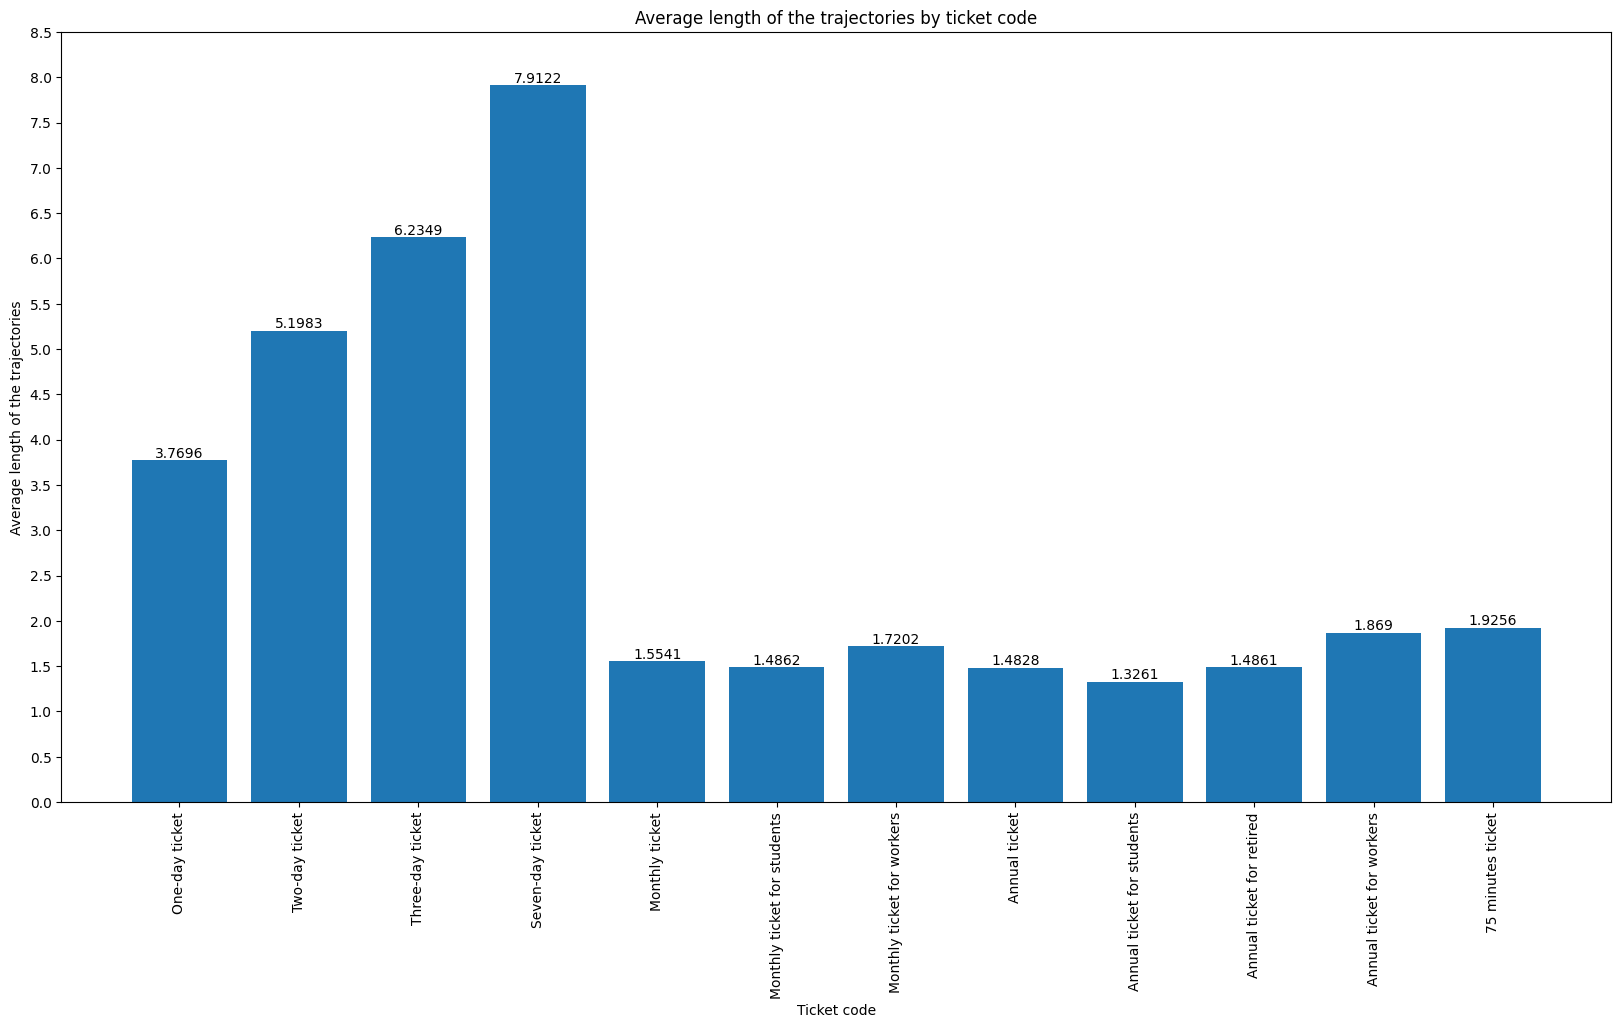

In [97]:
# Compute the average length of the trajectories
average_lenght = average_length_of_trajectories(dict_trajectories)
print('The average length of the trajectories considering all the dataframe is: {}'.format(average_lenght))
average_length_of_trajectories_by_ticket_code_plot(dict_trajectories, df)

### Compute the average length of the trajectories with the dataset with the ticket code 7

In [98]:
# # Create a dictionary with the trajectories of the users with the ticket code '7'
# df_sup = mf.focus_on_ticket_code(df,'7')
# # Create a dictionary with the trajectories of the users
# dict_trajectories = create_dictionary_with_trajectories(df_sup)
# # Compute the average length of the trajectories
# average_lenght = average_length_of_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='7')
# # average_length_of_trajectories_by_ticket_code_plot(dict_trajectories, df_sup, 'data/dictionaries/dict_ticket_codes.json')
# # trajectories_with_at_least_k_stations(dict_trajectories, 3)

### Print information for each ticket code

In [99]:
# For each ticket code:
# a. Create a dictionary with the trajectories of the users with the ticket code
# b. Compute the average length of the trajectories (number of stations visited)
# c. Compute the number of users 
# d. Compute the number of trajectories
# e. Find the most frequent trajectories

ticket_code = mf.open_dict_ticket_codes()

dict_trajectories = create_dictionary_with_trajectories(df)
# average_length_of_trajectories_by_ticket_code_plot(dict_trajectories, df, 'data/dictionaries/dict_ticket_codes.json')

for ticket_code in ticket_code.keys():
    # Exclude the ticket code '8' 
    if ticket_code == '8':
        continue
    
    print('Ticket code: {} - "{}"'.format(ticket_code, mf.get_ticket_code_description(ticket_code)))

    # a. Create a dictionary with the trajectories of the users with the ticket code
    df_sup = mf.focus_on_ticket_code(df, ticket_code)
    dict_trajectories = create_dictionary_with_trajectories(df_sup)
    if len(dict_trajectories.keys()) == 0:
        print('\t No trajectories to analyze')
        print('')
        continue
    
    # b. Compute the average length of the trajectories (number of stations visited)
    avg_len_trj = average_length_of_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code)
    print('The average length of the trajectories is: {}'.format(avg_len_trj))
    
    # c. Compute the number of users (Seriale)
    number_of_users = len(dict_trajectories.keys()) # TODO: r u sure?
    
    # d. Compute the number of trajectories
    num_trj = number_of_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code, summary=False)
    print('The number of trajectories is: {}'.format(num_trj))
    
    # e. Find the most frequent trajectories
    most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code=ticket_code, k=5, summary=True, min_length=2)
    print('')

Ticket code: 1 - "One-day ticket"
The average length of the trajectories is: 3.7696
The number of trajectories is: 3636
The most 5 frequent trajectories with a minimum length of 2 stop(s) for the ticket code 1 - "One-day ticket" are:
	 [['F.TE NOVE', 'BURANO']] - 232
	 [['F.TE NOVE', 'MURANO', 'BURANO']] - 171
	 [['SAN MARCO', 'BURANO']] - 162
	 [['SAN MARCO', 'MURANO', 'BURANO']] - 126
	 [['F.TE NOVE', 'BURANO', 'MURANO']] - 119

Ticket code: 2 - "Two-day ticket"
The average length of the trajectories is: 5.1983
The number of trajectories is: 2116
The most 5 frequent trajectories with a minimum length of 2 stop(s) for the ticket code 2 - "Two-day ticket" are:
	 [['FERROVIA', 'RIALTO']] - 27
	 [['FERROVIA', 'SAN MARCO']] - 23
	 [['FERROVIA', 'S. MARCO-SAN']] - 20
	 [['P.LE ROMA', 'RIALTO']] - 14
	 [['TRONCHETTO', 'RIALTO']] - 12

Ticket code: 3 - "Three-day ticket"
The average length of the trajectories is: 6.2349
The number of trajectories is: 2065
The most 5 frequent trajectories wit

In [100]:
def print_trajectories_of_user(dict_trajectories: dict, user: str):
    """
        This function prints the trajectories of a user.
        :param dict_trajectories: the dictionary with the trajectories
        :param user: the user
    """
    # print the dataframes of the trajectories of the user
    df_aux = df[df['SERIALE'] == user]
    print(df_aux)

In [101]:
# Given the serial of a user, print the trajectories of the user
# Serial of the user of the first trajectory
serial = list(dict_trajectories.keys())[0][0]
# Print the trajectories of the user
print_trajectories_of_user(dict_trajectories, serial)

        DATA       ORA     DATA_VALIDAZIONE            SERIALE  FERMATA  \
0 2023-01-13  00:00:00  2023-01-13 00:00:00  40834866809772548      162   

    DESCRIZIONE  TITOLO TICKET_CODE           DESCRIZIONE_TITOLO  
0  STAZIONE MES   12101           7  BIGL.AUT.75'MESTRE/LIDO-TSC  


### Find the most frequent trajectories with the entire dataset

In [102]:
# Create a dictionary with the trajectories of the users with the entire dataset
dict_trajectories = create_dictionary_with_trajectories(df)
# Find the most frequent trajectories and print the summary
most_freq_trj = most_frequent_trajectories(dict_trajectories, k=20, summary=True, min_length=3)

The most 20 frequent trajectories with a minimum length of 3 stop(s) are:
	 [['F.TE NOVE', 'MURANO', 'BURANO']] - 182
	 [['P.LE ROMA', 'RIALTO', 'P.LE ROMA', 'RIALTO']] - 165
	 [['P.LE ROMA', 'RIALTO', 'VENEZIA']] - 145
	 [['SAN MARCO', 'MURANO', 'BURANO']] - 130
	 [['P.LE ROMA', 'RIALTO', 'P.LE ROMA']] - 126
	 [['P.LE ROMA', 'RIALTO', 'RIALTO']] - 125
	 [['F.TE NOVE', 'BURANO', 'MURANO']] - 125
	 [['P.LE ROMA', 'P.LE ROMA', 'RIALTO']] - 102
	 [['FERROVIA', 'MURANO', 'BURANO']] - 100
	 [['RIALTO', 'P.LE ROMA', 'RIALTO']] - 93
	 [['LIDO', 'LIDO', 'S. MARCO-SAN']] - 81
	 [['RIALTO', 'RIALTO', 'RIALTO']] - 79
	 [['P.LE ROMA', 'MURANO', 'BURANO']] - 75
	 [['LIDO', 'S. MARCO-SAN', 'LIDO']] - 74
	 [['PUNTA SABBIO', 'LIDO', 'LIDO']] - 70
	 [['PUNTA SABBIO', 'LIDO', 'SAN MARCO']] - 70
	 [['TRONCHETTO', 'LIDO', 'TRONCHETTO', 'LIDO']] - 64
	 [['FERROVIA', 'RIALTO', 'RIALTO']] - 63
	 [['PUNTA SABBIO', 'SAN MARCO', 'PUNTA SABBIO', 'SAN MARCO']] - 56
	 [['PUNTA SABBIO', 'S. MARCO-SAN', 'SAN MARCO']

### Find the most frequent trajectories with the dataset with a specified ticket code

In [103]:
# Create a dictionary with the trajectories of the users with the ticket code '1'
df_sup = mf.focus_on_ticket_code(df,'1')
# Create a dictionary with the trajectories of the users with the ticket code '1'
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='1', summary=False, k = -1, min_length=4)

In [104]:
# Which are the common itineraries for tourists? 
# The tourist have the ticket code '1', '2', '3', '4'
# Create a dictionary with the trajectories of the users with the ticket code '1', '2', '3', '4'
df_sup = mf.focus_on_ticket_code_list(df,['1','2','3','4'])
# Create a dictionary with the trajectories of the users with the ticket code '1', '2', '3', '4'
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 20, min_length=4, summary=True)

The most 20 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['FERROVIA', 'RIALTO', 'FERROVIA', 'BURANO', 'FERROVIA', 'RIALTO', 'FERROVIA']] - 28
	 [['F.TE NOVE', 'MURANO', 'MURANO', 'BURANO']] - 25
	 [['FERROVIA', 'MURANO', 'BURANO', 'RIALTO']] - 25
	 [['FERROVIA', 'F.TE NOVE', 'BURANO', 'MURANO']] - 21
	 [['FERROVIA', 'F.TE NOVE', 'BURANO', 'RIALTO']] - 20
	 [['SAN MARCO', 'MURANO', 'MURANO', 'BURANO']] - 18
	 [['FERROVIA', 'MURANO', 'BURANO', 'MURANO']] - 17
	 [['F.TE NOVE', 'MURANO', 'BURANO', 'S. MARCO-SAN']] - 16
	 [['F.TE NOVE', 'MURANO', 'BURANO', 'RIALTO']] - 16
	 [['F.TE NOVE', 'MURANO', 'BURANO', 'SAN MARCO']] - 16
	 [['SAN MARCO', 'BURANO', 'MURANO', 'SAN MARCO']] - 15
	 [['SAN MARCO', 'MURANO', 'BURANO', 'F.TE NOVE']] - 15
	 [['FERROVIA', 'MURANO', 'BURANO', 'F.TE NOVE']] - 15
	 [['SAN MARCO', 'MURANO', 'BURANO', 'RIALTO']] - 14
	 [['P.LE ROMA', 'MURANO', 'BURANO', 'VENEZIA']] - 14
	 [['PEOPLE MOVER', 'P.LE ROMA', 'MURANO', 'BURANO', 'SAN MARCO', 'S. GIORGI

In [105]:
# Which are the common itineraries for not tourists?
# The not tourist have the ticket code different from '1', '2', '3', '4'
# Create a dictionary with the trajectories of the users with the ticket code different from '1', '2', '3', '4'
df_sup = mf.focus_on_ticket_code_list(df,['5', '5-WKRS', '5-STUD', '5-RET', '6', '6-WKRS', '6-STUD', '6-RET'])
# Create a dictionary with the trajectories of the users with the ticket code different from '1', '2', '3', '4'
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 20, min_length=4, summary=True)


The most 20 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['P.LE ROMA', 'RIALTO', 'P.LE ROMA', 'RIALTO']] - 134
	 [['LIDO', 'S. MARCO-SAN', 'LIDO', 'S. MARCO-SAN']] - 31
	 [['PEOPLE MOVER', 'P.LE ROMA', 'RIALTO', 'PEOPLE MOVER']] - 26
	 [['RIALTO', 'P.LE ROMA', 'RIALTO', 'P.LE ROMA']] - 21
	 [['S. TOMA\' "B"', 'RIALTO', 'S. TOMA\' "B"', 'RIALTO']] - 21
	 [['S. ANGELO', 'S. TOMA\' "B"', 'S. ANGELO', 'S. TOMA\' "B"']] - 19
	 [['S. STAE', 'S. MARCUOLA-', 'S. STAE', 'S. MARCUOLA-']] - 16
	 [['S.ELENA-STAD', 'S. MARCO-SAN', 'S.ELENA-STAD', 'S. MARCO-SAN']] - 16
	 [['MESTRE', 'P.LE ROMA', 'RIALTO', 'VENEZIA']] - 15
	 [['P.LE ROMA', 'RIALTO', 'RIALTO', 'RIALTO']] - 14
	 [['RIALTO', 'S. TOMA\' "B"', 'RIALTO', 'S. TOMA\' "B"']] - 14
	 [['PEOPLE MOVER', 'PEOPLE MOVER', 'PEOPLE MOVER', 'PEOPLE MOVER']] - 14
	 [['PUNTA SABBIO', 'S. MARCO-SAN', 'S. TOMA\' "B"', 'SAN MARCO']] - 13
	 [['S.ELENA-STAD', 'LIDO', 'S.ELENA-STAD', 'LIDO']] - 12
	 [['S. MARCUOLA-', 'RIALTO', 'S. MARCUOLA-

In [106]:
# Which are the common itineraries for students?
# The students have the ticket code '5-STUD', '6-STUD'
# Create a dictionary with the trajectories of the users with the ticket code '5-STUD', '6-STUD'
df_sup = mf.focus_on_ticket_code_list(df,['5-STUD', '6-STUD'])
# Create a dictionary with the trajectories of the users with the ticket code '5-STUD', '6-STUD'
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 20, min_length=4, summary=True)


The most 20 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['P.LE ROMA', 'RIALTO', 'P.LE ROMA', 'RIALTO']] - 14
	 [['LIDO', 'BURANO', 'MURANO', 'P.LE ROMA']] - 6
	 [['LIDO', 'BURANO', 'MURANO', 'BURANO', 'P.LE ROMA']] - 4
	 [['SALUTE', 'GUGLIE', 'FERROVIA', 'RIALTO']] - 4
	 [['P.LE ROMA', 'RIALTO', 'FERROVIA', 'RIALTO']] - 3
	 [['PALEOCAPA PA', 'P.LE ROMA', 'RIALTO', 'VENEZIA']] - 3
	 [['S.ELENA-STAD', 'LIDO', 'S.ELENA-STAD', 'LIDO']] - 3
	 [['GALLO', 'LIDO', 'FERROVIA', 'SANTA MARIA ']] - 3
	 [['SAN MARCO', 'GIUDECCA PAL', 'P.LE ROMA', 'GIUDECCA PAL']] - 2
	 [['S. MARCO-SAN', 'LIDO', 'S. MARCO-SAN', 'LIDO']] - 2
	 [['MESTRE', 'MESTRE', 'SAN MARCO', 'MESTRE']] - 2
	 [['PEOPLE MOVER', 'P.LE ROMA', 'RIALTO', 'PEOPLE MOVER']] - 2
	 [['RIALTO', 'VENEZIA', 'MESTRE', 'P.LE ROMA']] - 2
	 [['LIDO', 'SAN MARCO', 'LIDO', 'S. MARCO-SAN']] - 2
	 [['S. BASILIO', 'REDENTORE', 'S. BASILIO', 'REDENTORE']] - 2
	 [['GIUDECCA PAL', 'GIUDECCA PAL', 'GIUDECCA PAL', 'ZATTERE']] - 2
	 [['P.

In [107]:
# Which are the common itineraries for workers?
# The workers have the ticket code '5-WKRS', '6-WKRS'
# Create a dictionary with the trajectories of the users with the ticket code '5-WKRS', '6-WKRS'
df_sup = mf.focus_on_ticket_code_list(df,['5-WKRS', '6-WKRS'])
# Create a dictionary with the trajectories of the users with the ticket code '5-WKRS', '6-WKRS'
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 20, min_length=4, summary=True)

The most 20 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['PUNTA SABBIO', 'S. MARCO-SAN', 'S. TOMA\' "B"', 'SAN MARCO']] - 6
	 [['PUNTA SABBIO', 'LIDO', 'S. STAE', 'SAN MARCO']] - 3
	 [['PUNTA SABBIO', 'SAN MARCO', 'PUNTA SABBIO', 'LIDO', 'FERROVIA', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'TOSATTO', 'P.LE ROMA', 'LIDO']] - 1
	 [['PUNTA SABBIO', 'VENEZIA', 'TOSATTO', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'SAN MARCO', 'LIDO', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'SAN MARCO', 'GIUDECCA PAL', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'S. MARCO VAL', 'S. MARCUOLA-', 'SAN MARCO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'GIUDECCA PAL', 'LIDO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'S. MARCO VAL', 'LIDO']] - 1
	 [['PUNTA SABBIO', 'LIDO', 'GIUDECCA PAL', 'ZATTERE', 'LIDO']] - 1


In [108]:
# Which are the common itineraries for retired?
# The retired have the ticket code '5-RET', '6-RET'
# Create a dictionary with the trajectories of the users with the ticket code '5-RET', '6-RET'
df_sup = mf.focus_on_ticket_code_list(df,['5-RET', '6-RET'])
# Create a dictionary with the trajectories of the users with the ticket code '5-RET', '6-RET'
dict_trajectories = create_dictionary_with_trajectories(df_sup)
# Save the most frequent trajectories in a variable
most_frq_trj = most_frequent_trajectories(dict_trajectories, k = 20, min_length=4, summary=True)

The most 20 frequent trajectories with a minimum length of 4 stop(s) are:
	 [['S. TOMA\' "B"', 'RIALTO', 'S. TOMA\' "B"', 'RIALTO']] - 5
	 [['PUNTA SABBIO', 'LIDO', 'GIUDECCA PAL', 'LIDO']] - 2
	 [['GIARDINI', 'RIALTO', 'ZATTERE', 'SAN PIETRO', 'MADONNA']] - 2
	 [['CA', 'CAPPUCCINA', 'MESTRE', 'CA']] - 1
	 [['TERRAGLIO', 'EINAUDI CAST', 'GARIBALDI', 'CARDUCCI']] - 1
	 [['CA', 'CA', 'SAN DONA', 'MESTRE']] - 1
	 [['DE NICOLA CH', 'DE NICOLA CH', 'SAN DONA', 'MESTRE']] - 1
	 [['MARTELLAGO', 'S. MARCO-SAN', 'GIARDINI', 'MESTRE']] - 1
	 [['SAN DONA', 'MESTRE', 'SALAMONIO MA', 'MESTRE', 'TRIESTINA']] - 1
	 [['ZATTERE', 'GIUDECCA PAL', 'P.LE ROMA', 'GIUDECCA PAL', 'RIALTO']] - 1
	 [['PERTINI', 'PERTINI', 'MESTRE', 'P.LE ROMA', 'LIDO']] - 1
	 [['VENEZIA', 'BISSUOLA', 'PERTINI', 'MESTRE', 'MESTRE']] - 1
	 [['CIRCONVALLAZ', 'TORINO', 'CIRCONVALLAZ', 'BISSUOLA']] - 1
	 [['MURANO', 'CORSO DEL PO', 'CORSO DEL PO', 'P.LE ROMA']] - 1
	 [['DON', 'DON', 'PASQUALIGO M', 'PASQUALIGO M']] - 1
	 [['RIALTO'

### Find the most frequent trajectories with the dataset with a specified ticket code


In [ ]:
# # Create a dictionary with the trajectories of the users with the ticket code '1'
# df_sup = mf.focus_on_ticket_code(df,'1')
# # Create a dictionary with the trajectories of the users with the ticket code '1'
# dict_trajectories = create_dictionary_with_trajectories(df_sup)
# # Find the trajectories with at least 20 stations visited with the ticket code '1'
# trajectories_with_at_least_k_stations(dict_trajectories, 4)

### Longest Common Subsequence (LCS)

In [ ]:
def longest_common_subsequence_of_two_trajectories (trajectory_1: list, trajectory_2: list) -> list:
    """
        This function computes the longest common subsequence of two trajectories.
        :param trajectory_1: the first trajectory
        :param trajectory_2: the second trajectory
        :return: the longest common subsequence of the two trajectories
    """
    # Create the matrix
    matrix = [[0 for x in range(len(trajectory_2) + 1)] for x in range(len(trajectory_1) + 1)]

    # Compute the LCS
    for i in range(1, len(trajectory_1) + 1):
        for j in range(1, len(trajectory_2) + 1):
            if trajectory_1[i - 1] == trajectory_2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1] + 1
            else:
                matrix[i][j] = max(matrix[i - 1][j], matrix[i][j - 1])

    # Find the LCS
    i = len(trajectory_1)
    j = len(trajectory_2)
    lcs = []
    while i > 0 and j > 0:
        if trajectory_1[i - 1] == trajectory_2[j - 1]:
            lcs.append(trajectory_1[i - 1])
            i -= 1
            j -= 1
        elif matrix[i - 1][j] > matrix[i][j - 1]:
            i -= 1
        else:
            j -= 1

    # Reverse the LCS
    lcs.reverse()

    return lcs

In [ ]:
def longest_common_subsequence (dict_trajectories: dict):
    """
        This function computes the longest common subsequence of the trajectories of the dictionary.
        :param dict_trajectories: the dictionary with the trajectories
        :return: the longest common subsequence
    """

    # Compute the longest common subsequence
    # The trajectories of the dictionary are the keys of the dictionary
    trajectories = list(dict_trajectories.keys())
    lcs = trajectories[0]
    for i in range(1, len(trajectories)):
        lcs = longest_common_subsequence_of_two_trajectories(lcs, trajectories[i])

In [ ]:
def shortest_common_supersequence_of_two_trajectories (trajectory_1: list, trajectory_2: list) -> list:
    """
        This function computes the shortest common supersequence of two trajectories.
        :param trajectory_1: the first trajectory
        :param trajectory_2: the second trajectory
        :return: the shortest common supersequence of the two trajectories
    """
    # Create the matrix
    matrix = [[0 for x in range(len(trajectory_2) + 1)] for x in range(len(trajectory_1) + 1)]

    # Compute the SCS
    for i in range(1, len(trajectory_1) + 1):
        for j in range(1, len(trajectory_2) + 1):
            if trajectory_1[i - 1] == trajectory_2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1] + 1
            else:
                matrix[i][j] = max(matrix[i - 1][j], matrix[i][j - 1])

    # Find the SCS
    i = len(trajectory_1)
    j = len(trajectory_2)
    scs = []
    while i > 0 and j > 0:
        if trajectory_1[i - 1] == trajectory_2[j - 1]:
            scs.append(trajectory_1[i - 1])
            i -= 1
            j -= 1
        elif matrix[i - 1][j] > matrix[i][j - 1]:
            scs.append(trajectory_1[i - 1])
            i -= 1
        else:
            scs.append(trajectory_2[j - 1])
            j -= 1

    # Add the remaining elements of trajectory_1
    while i > 0:
        scs.append(trajectory_1[i - 1])
        i -= 1

    # Add the remaining elements of trajectory_2
    while j > 0:
        scs.append(trajectory_2[j - 1])
        j -= 1

    # Reverse the SCS
    scs.reverse()

    return scs

In [ ]:
def shortest_common_supersequence (dict_trajectories: dict) -> list:
    """
        This function computes the shortest common supersequence of the trajectories of the dictionary.
        :param dict_trajectories: the dictionary with the trajectories
        :return: the shortest common supersequence
    """

    # Compute the shortest common supersequence
    # The trajectories of the dictionary are the keys of the dictionary
    trajectories = list(dict_trajectories.keys())
    scs = trajectories[0]
    for i in range(1, len(trajectories)):
        scs = shortest_common_supersequence_of_two_trajectories(scs, trajectories[i])
    
    return scs

In [ ]:
# # Find the Longest Common Subsequence (LCS) between two trajectories
# trajectory_1 = ['SAN MARCO', 'P.LE ROMA', 'RIALTO', 'PUNTA SABBIO', 'BURANO']
# trajectory_2 = ['SAN MARCO', 'P.LE ROMA', 'PUNTA SABBIO', 'BURANO']

# lcs = longest_common_subsequence(trajectory_1, trajectory_2)
# print('The Longest Common Subsequence (LCS) between the trajectories {} and {} is {}'.format(trajectory_1, trajectory_2, lcs))

In [ ]:
# # Find the Longest Common Subsequence (LCS) between two trajectories
# # Trajectory 1 is the trajectory of the dataset with the ticket code 1
# # Trajectory 2 is the most frequent trajectory of the dataset with the ticket code 2
# df_sup = mf.focus_on_ticket_code(df,'1')
# dict_trajectories = create_dictionary_with_trajectories(df_sup)
# dict_trajectories_number = most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='1', summary=False)
# trajectory_1 = list(dict_trajectories_number.keys())[8]

# df_sup = mf.focus_on_ticket_code(df,'2')
# dict_trajectories = create_dictionary_with_trajectories(df_sup)
# dict_trajectories_number = most_frequent_trajectories(dict_trajectories, is_focus_on_ticket_code=True, ticket_code='2', summary=False)
# trajectory_2 = list(dict_trajectories_number.keys())[0]

# lcs = longest_common_subsequence(trajectory_1, trajectory_2)
# print('The Longest Common Subsequence (LCS) between the trajectory {} and the trajectory {} is {}'.format(trajectory_1, trajectory_2, lcs))

_____

In [ ]:
def most_frequent_stations_visited_by_the_users (dict_trajectories: dict, is_focus_on_ticket_code: bool = False, ticket_code: str = "", summary: bool = False) -> dict:
    """
        This function finds the most frequent stations visited by the users.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :param is_focus_on_ticket_code: if True, the function is focused on the ticket code
        :param ticket_code: the ticket code
        :param summary: if True, the function prints the summary
        :return: the dictionary with the most frequent stations visited by the users
    """
    # Create a dictionary with the most frequent stations visited by the users
    dict_stations = {}
    
    # For each trajectory
    for trajectory in dict_trajectories.keys():
        # For each station in the trajectory
        for station in dict_trajectories[trajectory]:
            # If the station is not in the dictionary, add it
            if station not in dict_stations.keys():
                dict_stations[station] = 1
            # If the station is in the dictionary, increment its value
            else:
                dict_stations[station] += 1

    # Sort the dictionary with the most frequent stations visited by the users
    dict_stations = {k: v for k, v in sorted(dict_stations.items(), key=lambda item: item[1], reverse=True)}

    # Print the summary
    if summary and is_focus_on_ticket_code:
        print('The most frequent stations visited by the users with the ticket code {} are:'.format(ticket_code))
        for station in dict_stations.keys():
            print('The station {} is visited {} times'.format(station, dict_stations[station]))
    elif summary:
        print('The most frequent stations visited by the users are:')
        for station in dict_stations.keys():
            print('The station {} is visited {} times'.format(station, dict_stations[station]))

    return dict_stations

In [ ]:
def rearrange_dictionary_with_trajectories (dict_trajectories: dict) -> dict:
    """
        This function rearranges the dictionary with the trajectories of the users.
        :param dict_trajectories: the dictionary with the trajectories of the users
        :return: the rearranged dictionary with the trajectories of the users
    """
    # Create the rearranged dictionary with the trajectories of the users
    dict_trajectories_rearranged = {}

    # For each trajectory
    for trajectory in dict_trajectories.keys():
        # For each station in the trajectory
        for station in dict_trajectories[trajectory]:
            # If the station is not in the dictionary, add it
            if station not in dict_trajectories_rearranged.keys():
                dict_trajectories_rearranged[station] = [trajectory]
            # If the station is in the dictionary, append the trajectory
            else:
                dict_trajectories_rearranged[station].append(trajectory)

    return dict_trajectories_rearranged

In [ ]:
# # Are there typical patterns in the movements of the users? 
# # Using different clustring techniques, find the most frequent trajectories and the most frequent stations visited by the users.
# # Create a dictionary with the trajectories of the users with the entire dataset
# dict_trajectories = create_dictionary_with_trajectories(df)
# # Find the most frequent trajectories and print the summary
# most_frequent_trajectories(dict_trajectories, summary=False)
# # Find the most frequent stations visited by the users and print the summary
# most_frequent_stations_visited_by_the_users(dict_trajectories, summary=False)

# # Cluster the users using the K-Means algorithm
# # Create a dictionary with the trajectories of the users with the entire dataset
# # dict_trajectories = create_dictionary_with_trajectories(df)
# # Cluster the users using the K-Means algorithm
# from sklearn.cluster import KMeans

# merged_list = sum([sublist for sublist in list(dict_trajectories.values())], [])

# # Cluster the users using the K-Means algorithm
# kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(merged_list))
# # Create a dictionary with the clusters
# dict_clusters = {}
# for i in range(len(kmeans.labels_)):
#     if kmeans.labels_[i] not in dict_clusters.keys():
#         dict_clusters[kmeans.labels_[i]] = []
#     dict_clusters[kmeans.labels_[i]].append(list(dict_trajectories.keys())[i])
# # Print the summary
# print('The clusters are:')
# for cluster in dict_clusters.keys():
#     print('The cluster {} contains the following trajectories:'.format(cluster))
#     for trajectory in dict_clusters[cluster]:
#         print(trajectory)